In [ ]:

import os # for file handling
import pickle # store numpy featues 
import numpy as np
from tqdm.notebook import tqdm

from tensorflow.keras.applications.vgg16 import VGG16, preprocess_input
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Model
from tensorflow.keras.utils import to_categoricanpl, plot_model
from tensorflow.keras.layers import Iut, Dense, LSTM, Embedding, Dropout, add

In [ ]:
# VGG16= visual geometry group model who won image net competition in 2014
# 16 depicts the number of weight models 
# it is CNN based model based on 3*3 convolution layer 
# volume size reduction is done my maxpooling 
# 2 FC layers with 4096 nodes with softmax classifier 
# kera provides this pretrained model

# it has another varient called VGG19
# another advanced arch. called RESNET allow us to train at depth of 60 to 200
# note = vgg19 and resnet is not used due to system capacity limitations

# tensorflow lab version suppose to be > 2.0

In [ ]:
BASE_DIR = '/content/drive/MyDrive/project_dataset'
WORKING_DIR = '/content/drive/MyDrive/project_working1'

# Extract Image Features

In [ ]:
# load vgg16 model
model = VGG16()
# restructure the model
model = Model(inputs=model.inputs, outputs=model.layers[-2].output)
        # inputs=model.inputs==> this is image input 
        #  outputs=model.layers[-2].output ==> since we don't need FC of the VGG16 model. bcoz VGG16 is used for the classification.
# summarize
print(model.summary())

553467096/553467096 [==============================] - 19s 0us/step
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                           


tqdm is a library in Python which is used for creating Progress Meters or Progress Bars.



load_img() ==> to load the image into PIL format 
PIL stands for Python Image Library. The library provides support for various image formats including the popular JPEG and PNG formats.



img_to_array() ==> Converts a PIL Image instance to a Numpy array.
Converting an image to an array is an important task to train a machine learning model based on the features of an image.it will Returns
A 3D Numpy array.



reshape() ==> Most convolutional neural networks are designed in a way so that they can only accept images of a fixed size. This creates several challenges during data acquisition and model deployment. The common practice to overcome this limitation is to reshape the input images so that they can be fed into the networks.



preprocess_input() ==>Keras works with batches of images. So, the first dimension is used for the number of samples (or images) you have.
When you load a single image, you get the shape of one image, which is (size1,size2,channels).In order to create a batch of images, you need an additional dimension: (samples, size1,size2,channels).The preprocess_input function is meant to adequate your image to the format the model requires.



Pickle can be used to serialize Python object structures, which refers to the process of converting an object in the memory to a byte stream that can be stored as a binary file on disk. When we load it back to a Python program, this binary file can be de-serialized back to a Python object.



dump() ==> dump() function to store the object data to the file. pickle. dump() function takes 3 arguments. The first argument is the object that you want to store. The second argument is the file object you get by opening the desired file in write-binary (wb) mode.



os.listdir() method ==> is used to get the list of all files and directories in the specified directory.



target_size=(224, 224) ==>  this will reduce the image resulation. here we might loose some data 


predict() ==> function enables us to predict the labels of the data values on the basis of the trained model.accepts only a single argument which is usually the data to be tested.It returns the labels of the data passed as argument based upon the learned or trained data obtained from the model.
Thus, the predict() function works on top of the trained model and makes use of the learned label to map and predict the labels for the data to be tested.

plot_model() ==>Converts a Keras model to dot format and save to a file.



In [ ]:
# # extract features from image. where each imageID we will have corrospnding features
# features = {} 
#         # key ==> will be the image ID 
#         # value ==>  is the features 
# directory = os.path.join(BASE_DIR, 'Images') # inside the base directory Images folder is accessed 

# for img_name in tqdm(os.listdir(directory)):
#     # load the image from file
#     img_path = directory + '/' + img_name
#     image = load_img(img_path, target_size=(224, 224))
#     # convert image pixels to numpy array
#     image = img_to_array(image)
#     # reshape data for model
#     image = image.reshape((1, image.shape[0], image.shape[1], image.shape[2]))
#     # preprocess image for vgg
#     image = preprocess_input(image)
#     # extract features
#     feature = model.predict(image, verbose=0)
#     # get image ID
#     image_id = img_name.split('.')[0]
#     # store feature
#     features[image_id] = feature

  0%|          | 0/8091 [00:00<?, ?it/s]

In [ ]:
# # store features in pickle
# pickle.dump(features, open(os.path.join(WORKING_DIR, 'features.pkl'), 'wb'))

# # wb ==> write binary       

In [ ]:
# load features from pickle
with open(os.path.join(WORKING_DIR, 'features.pkl'), 'rb') as f:
    features = pickle.load(f)

#  rb ==> read binary

In [ ]:
len(features)

# 8091

8091

# Load the Captions Data

In [ ]:
with open(os.path.join(BASE_DIR, 'captions (1).txt'), 'r') as f:
    next(f)
    captions_doc = f.read()

In [ ]:
 captions_doc

Output hidden; open in https://colab.research.google.com to view.

In [ ]:
len(captions_doc)

# 3319280

3319280

In [ ]:
# create mapping of image to captions
mapping = {}
# process lines
for line in tqdm(captions_doc.split('\n')):
    # split the line by comma(,)
    tokens = line.split(',')
    # tokens[0] ==> will be image_id
    # tokens[1] ==> will be the image caption
    if len(line) < 2:
        continue
    image_id, caption = tokens[0], tokens[1:]
    # remove extension from image ID
    image_id = image_id.split('.')[0]
    # convert caption list to string 
    caption = " ".join(caption)
    # create list if needed
    if image_id not in mapping:
        mapping[image_id] = []
    # store the caption
    mapping[image_id].append(caption)
    # 40456/40456

  0%|          | 0/40456 [00:00<?, ?it/s]

In [ ]:
len(mapping)

# 8091

8091

# Preprocess Text Data

step 1 = conerting text to lower case.

step 2 = remove punctuation. 

step 3 = removing single latter word (like a). 

step 4 = removing any number/s in the token.

In [ ]:
def clean(mapping):
    for key, captions in mapping.items():
        for i in range(len(captions)):
            # take one caption at a time
            caption = captions[i]
            # preprocessing steps
            # convert to lowercase
            caption = caption.lower()
            # delete digits, special chars, etc., 
            caption = caption.replace('[^A-Za-z]', '')
            # delete additional spaces
            caption = caption.replace('\s+', ' ')
            # add start and end tags to the caption
            caption = '<start> ' + " ".join([word for word in caption.split() if len(word)>1]) + '  <end>'
            captions[i] = caption

In [ ]:
# before preprocess of text
mapping['1000268201_693b08cb0e']

['A child in a pink dress is climbing up a set of stairs in an entry way .',
 'A girl going into a wooden building .',
 'A little girl climbing into a wooden playhouse .',
 'A little girl climbing the stairs to her playhouse .',
 'A little girl in a pink dress going into a wooden cabin .']

In [ ]:
# preprocess the text
# # don't run this cell multiple time 
# clean(mapping)

In [ ]:
# after preprocess of text
mapping['1000268201_693b08cb0e']

['<start> child in pink dress is climbing up set of stairs in an entry way  <end>',
 '<start> girl going into wooden building  <end>',
 '<start> little girl climbing into wooden playhouse  <end>',
 '<start> little girl climbing the stairs to her playhouse  <end>',
 '<start> little girl in pink dress going into wooden cabin  <end>']

In [ ]:
all_captions = []
for key in mapping:
    for caption in mapping[key]:
        all_captions.append(caption)

In [ ]:
len(all_captions)

# 40455

40455

In [ ]:
all_captions[:10]

['<start> child in pink dress is climbing up set of stairs in an entry way  <end>',
 '<start> girl going into wooden building  <end>',
 '<start> little girl climbing into wooden playhouse  <end>',
 '<start> little girl climbing the stairs to her playhouse  <end>',
 '<start> little girl in pink dress going into wooden cabin  <end>',
 '<start> black dog and spotted dog are fighting  <end>',
 '<start> black dog and tri-colored dog playing with each other on the road  <end>',
 '<start> black dog and white dog with brown spots are staring at each other in the street  <end>',
 '<start> two dogs of different breeds looking at each other on the road  <end>',
 '<start> two dogs on pavement moving toward each other  <end>']

Tokenization is used in natural language processing to split paragraphs and sentences into smaller units that can be more easily assigned meaning. The first step of the NLP process is gathering the data (a sentence) and breaking it into understandable parts (words).

The fit_on_texts method is a part of Keras tokenizer class which is used to update the internal vocabulary for the texts list. We need to call be before using other methods of texts_to_sequences or texts_to_matrix. word_counts : It is a dictionary of words along with the counts.

In [ ]:
# tokenize the text
tokenizer = Tokenizer()
tokenizer.fit_on_texts(all_captions)
vocab_size = len(tokenizer.word_index) + 1
# input_dim: Integer. Size of the vocabulary, i.e. maximum integer index + 1.

In [ ]:
vocab_size

# 8483

8483

In [ ]:
# get maximum length of the caption available
max_length = max(len(caption.split()) for caption in all_captions)
max_length

# 35

35

# Train Test Split

In [ ]:
        # 90% ==> will be train 
        # 10% ==> will be test
image_ids = list(mapping.keys())
split = int(len(image_ids) * 0.90)
train = image_ids[:split]
test = image_ids[split:]

In [ ]:
print(len(train))
print(len(test))

# 7281
# 810

7281
810


In [ ]:
# texts_to_sequences example ==>
#  '<start> girl going into wooden building  <end>',
# X                                                    y
# <start>                                            girl
# <start> girl                                      going
# <start> girl going                                 into
# <start> girl going into                            wooden
# ..
# ..
# ..
# <start> girl going into wooden building              <end> 



# to_categorical() ==> a vector which has integers that represent different categories,
#  can be converted into a numpy array (or) a matrix which has binary values and has 
#  columns equal to the number of categories in the data.
# i.e. if word is persented then it is repersented as 1 and rest will be zero

In [ ]:
# create data generator to get data in batch (avoids session crash)
# data_keys ==> is image id
# mapping ==> is pre-processed captions
# features ==> is image features after applyinng pre-trained model
# tokenizer ==> tokenzed captions 
# max_length ==> max length of caption i.e. 35 
# vocab_size ==> size of vocabulary +1 
# batch_size ==> 

# text_to_sequences ==> This class allows to vectorize a text corpus,
# by turning each text into either a sequence of integers (each integer
# being the index of a token in a dictionary) or into a vector
def data_generator(data_keys, mapping, features, tokenizer, max_length, vocab_size, batch_size):
    # loop over images
    X1, X2, y = list(), list(), list()
    n = 0 # to detrmaing that we reach at batch size or not 
    while 1:
        for key in data_keys:
            n += 1
            captions = mapping[key]
            # process each caption
            for caption in captions:
                # encode the sequence
                seq = tokenizer.texts_to_sequences([caption])[0]
                # split the sequence into X, y pairs
                for i in range(1, len(seq)):
                    # split into input and output pairs
                    in_seq, out_seq = seq[:i], seq[i]
                    # pad input sequence
                    in_seq = pad_sequences([in_seq], maxlen=max_length)[0]
                    # encode output sequence to have comman length
                    # we passing list so we here getting here 1 i.e. at zeroth index 
                    out_seq = to_categorical([out_seq], num_classes=vocab_size)[0]
                    
                    # store the sequences
                    X1.append(features[key][0])  # this is image features
                    X2.append(in_seq)            # text features 
                    y.append(out_seq)
            if n == batch_size:
                X1, X2, y = np.array(X1), np.array(X2), np.array(y)  # here we converting into arrays
                yield [X1, X2], y # this will return the collected samples to the generator and consumed by model
                X1, X2, y = list(), list(), list()
                n = 0

# Model Creation

In [ ]:
# image caption model containing ==>
#     1. handling text sequences and used as imput for the model
#             (Input, Dense, LSTM, Embedding, Dropout, add are used for text to vector conersion)
#     2. image features as a imput for the model

# merging thses 2 and used to predict the captions for the images  

# when ever we are passing words to emmbedding layer it should have same no of words, this is done with the help of pad sequences 

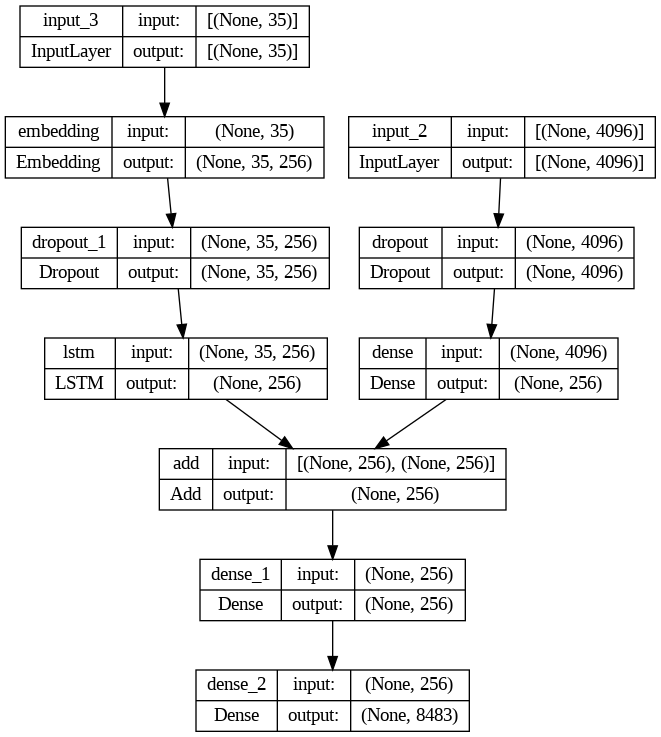

In [ ]:
# encoder model
# image feature layers
inputs1 = Input(shape=(4096,))             # in VGG model output is 4096, and that will be the input 
fe1 = Dropout(0.4)(inputs1)                # feature 1 
fe2 = Dense(256, activation='relu')(fe1)   # feature 2

# sequence feature layers
inputs2 = Input(shape=(max_length,))       # text sequenes 
se1 = Embedding(vocab_size, 256, mask_zero=True)(inputs2)
                # The model will take as input an integer matrix of size (batch,
                # input_length), and the largest integer (i.e. word index) in the input
                # should be no larger than 999 (vocabulary size).

                # output_dim: Integer. Dimension of the dense embedding.

                # mask_zero: Boolean, whether or not the input value 0 is a special "padding" value that should be masked out.
                # This is useful when using recurrent layers which may take variable length input. If this is True, then all subsequent
                # layers in the model need to support masking or an exception will be raised. If mask_zero is set to True,
                # as a consequence, index 0 cannot be used in the vocabulary (input_dim should equal size of vocabulary + 1).
                # more info ==>  tensorflow.org/guide/keras/masking_and_padding

                # 256 ==> is number of dimentions


                # The Dropout layer randomly sets input units to 0 at each step during training time,
                #  which helps prevent overfitting.
se2 = Dropout(0.4)(se1)
se3 = LSTM(256)(se2)

# decoder model
decoder1 = add([fe2, se3])
decoder2 = Dense(256, activation='relu')(decoder1)
outputs = Dense(vocab_size, activation='softmax')(decoder2)

model = Model(inputs=[inputs1, inputs2], outputs=outputs)
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

# plot the model
plot_model(model, show_shapes=True)

In [ ]:
# from tensorflow.keras.optimizers.legacy import Adam

In [ ]:
# train the model
epochs = 15
batch_size = 64
steps = len(train) // batch_size  # after eacch step it will do back-propogation and fetch the data 

for i in range(epochs):
    # create data generator
    generator = data_generator(train, mapping, features, tokenizer, max_length, vocab_size, batch_size)
    # fit for one epoch
    model.fit(generator, epochs=1, steps_per_epoch=steps, verbose=1)

113/113 [==============================] - 56s 499ms/step - loss: 2.4883 - accuracy: 0.4004


In [ ]:
# 227/227 [==============================] - 68s 301ms/step - loss: 2.1999 - accuracy: 0.4419
# epoch 20
# batch_size 32

In [ ]:
# 113/113 [==============================] - 56s 496ms/step - loss: 2.0108 - accuracy: 0.4765
# epochs = 10
# batch_size = 64

In [ ]:
# # save the model
# model.save(WORKING_DIR+'/VGG16_new.h5')

# Generate Captions for the Image

In [ ]:
# we have to conert image_id into word 
# all the words will get from the model it will be the index and index trasforms in to words 
def idx_to_word(integer, tokenizer):
    for word, index in tokenizer.word_index.items():
        if index == integer:
            return word
    return None

Tokenization is used in natural language processing to split paragraphs and sentences into smaller units that can be more easily assigned meaning.

t = Tokenizer()

test_text = ['Machine Learning Knowledge',
	      'Machine Learning',
             'Deep Learning',
             'Artificial Intelligence']

t.fit_on_texts(test_text)

sequences = t.texts_to_sequences(test_text)

print("The sequences generated from text are : ",sequences)


The sequences generated from text are :  [[2, 1, 3], [2, 1], [4, 1], [5, 6]]

Padding As we know all the neural networks needs to have the inputs that should be in similar shape and size. When we pre-process the texts and use the texts as an inputs for our Model. Note that not all the sequences have the same length, as we can say naturally some of the sequences are long in lengths and some are short. Where we know that we need to have the inputs with the same size, now here padding comes into picture. The inputs should be in same size at that time padding is necessary.



In [ ]:
# generate caption for an image
def predict_caption(model, image, tokenizer, max_length):
    # add start tag for generation process
    # tokenizer ==> 
    in_text = '<start>'
    # iterate over the max length of sequence, (we have max length of 35)  
    for i in range(max_length):
        # encode input sequence
        sequence = tokenizer.texts_to_sequences([in_text])[0]
        # pad the sequence
        sequence = pad_sequences([sequence], max_length)
        # predict next word
        # image ==> this will be the image features
        # sequence ==> this will be the captions sequenes 
        yhat = model.predict([image, sequence], verbose=0)
        # get index with high probability
        yhat = np.argmax(yhat)
        # convert index to word
        word = idx_to_word(yhat, tokenizer)
        # stop if word not found
        if word is None:
            break
        # append word as input for generating next word
        in_text += " " + word
        # stop if we reach end tag
        if word == '<end>':
            break
      
    return in_text

In [ ]:
# BLEU (BiLingual Evaluation Understudy) is a metric for automatically evaluating
#  machine-translated text. The BLEU score is a number between zero and one that 
#  measures the similarity of the machine-translated text to a set of high quality
#   reference translations.

In [ ]:
from nltk.translate.bleu_score import corpus_bleu
# validate with test data
actual, predicted = list(), list()

for key in tqdm(test):
    # get actual caption
    captions = mapping[key]
    # predict the caption for image
    y_pred = predict_caption(model, features[key], tokenizer, max_length) 
    # split into words
    actual_captions = [caption.split() for caption in captions]
    y_pred = y_pred.split()
    # append to the list
    actual.append(actual_captions)
    predicted.append(y_pred)
    
# calcuate BLEU score
print("BLEU-1: %f" % corpus_bleu(actual, predicted, weights=(1.0, 0, 0, 0)))
print("BLEU-2: %f" % corpus_bleu(actual, predicted, weights=(0.5, 0.5, 0, 0)))

  0%|          | 0/810 [00:00<?, ?it/s]

# Visualize the Results

In [ ]:
from PIL import Image
import matplotlib.pyplot as plt
def generate_caption(image_name):
    # load the image
    # image_name = "1001773457_577c3a7d70.jpg"
    image_id = image_name.split('.')[0]
    img_path = os.path.join(BASE_DIR, "Images", image_name)
    image = Image.open(img_path)
    captions = mapping[image_id]
    print('---------------------Actual---------------------')
    for caption in captions:
        print(caption)
    # predict the caption
    y_pred = predict_caption(model, features[image_id], tokenizer, max_length)
    print('--------------------Predicted--------------------')
    print(y_pred)
    plt.imshow(image)

In [ ]:
generate_caption("1001773457_577c3a7d70.jpg")